In [ ]:
"""
input:
    - main_configs.json
    - filtered_probs_8_200_0.2.parquet
    - date_topic_count_8_200_0.2.parquet
    - fisher_exact_test_results_ctm.parquet
output:
    - topic_distribution_bar_plot.svg
    - stachgraph_topic_modeling_smthd_percentage.pdf

    - ctm_volcano_plots/figure16B.svg
    - ctm_volcano_plots/figure16D.svg
    - ctm_volcano_plots/figure16F.svg
    - ctm_volcano_plots/figure16H.svg
    - ctm_volcano_plots/figure16J.svg
    - ctm_volcano_plots/figure16L.svg
    - ctm_volcano_plots/figure16N.svg
    - ctm_volcano_plots/figure16P.svg
"""

In [2]:
import os
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import FuncFormatter

from src.scripts.common_figures import Figures

In [3]:
with open("/src/main_configs.json", 'r') as f:
    main_configs = json.load(f)

probs_path = "/data/processed/CTM/probs"
supp_figures_path = "/figures/experimental/supp_figures"
main_figures_path = "/figures/experimental/main_figures"
dataframes_path = "/data/processed/dataframes"

figures = Figures()

# CTM Analysis

In [4]:
topics_predictions_df = pd.read_csv(f"{probs_path}/filtered_probs_8_200_0.2.parquet")

In [5]:
topics = np.argmax(topics_predictions_df.values, axis=1)
topic_counts = Counter(topics)
topic_counts

Counter({1: 782987,
         4: 744207,
         5: 811972,
         3: 378428,
         7: 1494646,
         2: 717668,
         6: 514453,
         0: 1018583})

In [6]:
topic_names = main_configs['topic_names']
topic_names[-3] = 'Politics and\nConspiracy Theories'

topic_counts_df = pd.DataFrame({'topic_name': topic_names,
                                'topic_count': [topic_counts[idx] for idx in range(len(topic_names))],
                                'percent': [topic_counts[idx] / topics_predictions_df.shape[0] for idx in range(len(topic_names))]})

colors = ["#a40000", "#16317d", "#007e2f", "#ffcd12", "#b86092", "#721b3e", "#00b7a7", "#e35e28"]

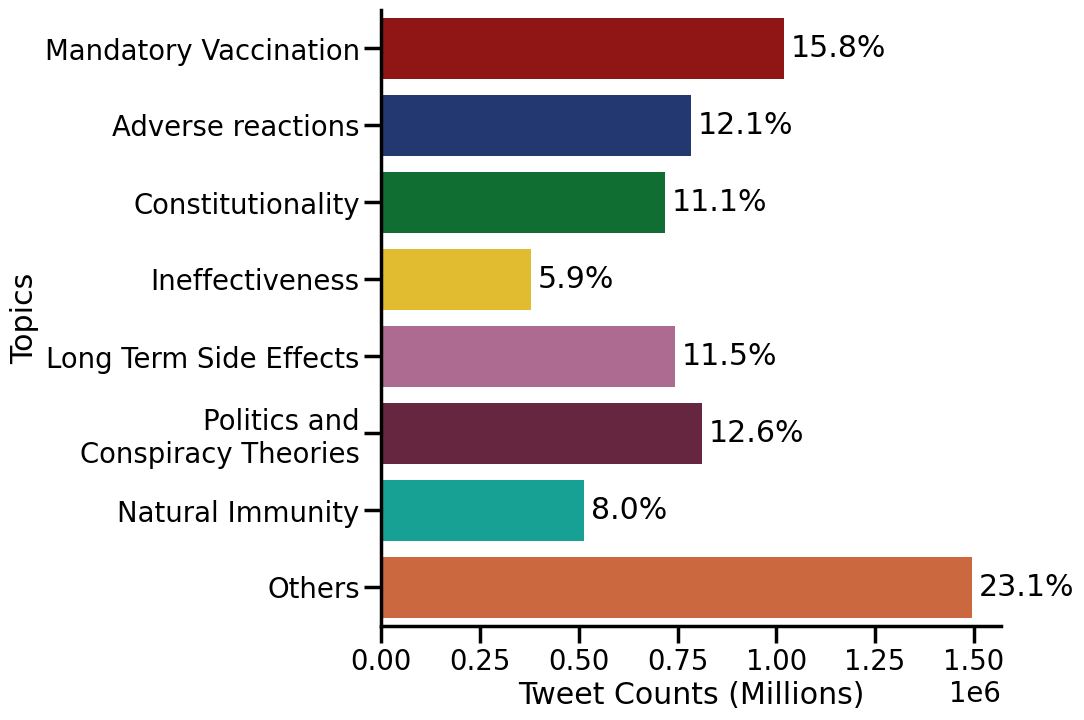

In [ ]:
sns.set_context('poster', font_scale=0.9)
plt.figure(figsize=(8, 8))
ax = sns.barplot(data=topic_counts_df, x='topic_count', y='topic_name', orient='h', palette=colors)
plt.xlabel('Tweet Counts (Millions)')
plt.ylabel('Topics')
for idx, p in enumerate(ax.patches):
    ax.annotate(f"{round(topic_counts_df['percent'][idx]*100, 1)}%", xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

sns.despine()
plt.savefig(f"{supp_figures_path}/topic_distribution_bar_plot.svg", bbox_inches='tight')

# Time Series By Topic

In [7]:
date_topic_count = pd.read_csv(f"{dataframes_path}/date_topic_count_8_200_0.2.parquet")

In [8]:
y_counts = [date_topic_count[date_topic_count['topic'] == topic].sort_values('date')['counts'].values for topic in range(1, 9)]

In [9]:
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

In [10]:
x = np.linspace(2020, 2022, num=y_counts[0].shape[0])
y_smthd = [gaussian_smooth(x, y_, x, 0.0045) for y_ in y_counts]

In [11]:
topic_names[-3] = 'Politics and Conspiracy Theories'

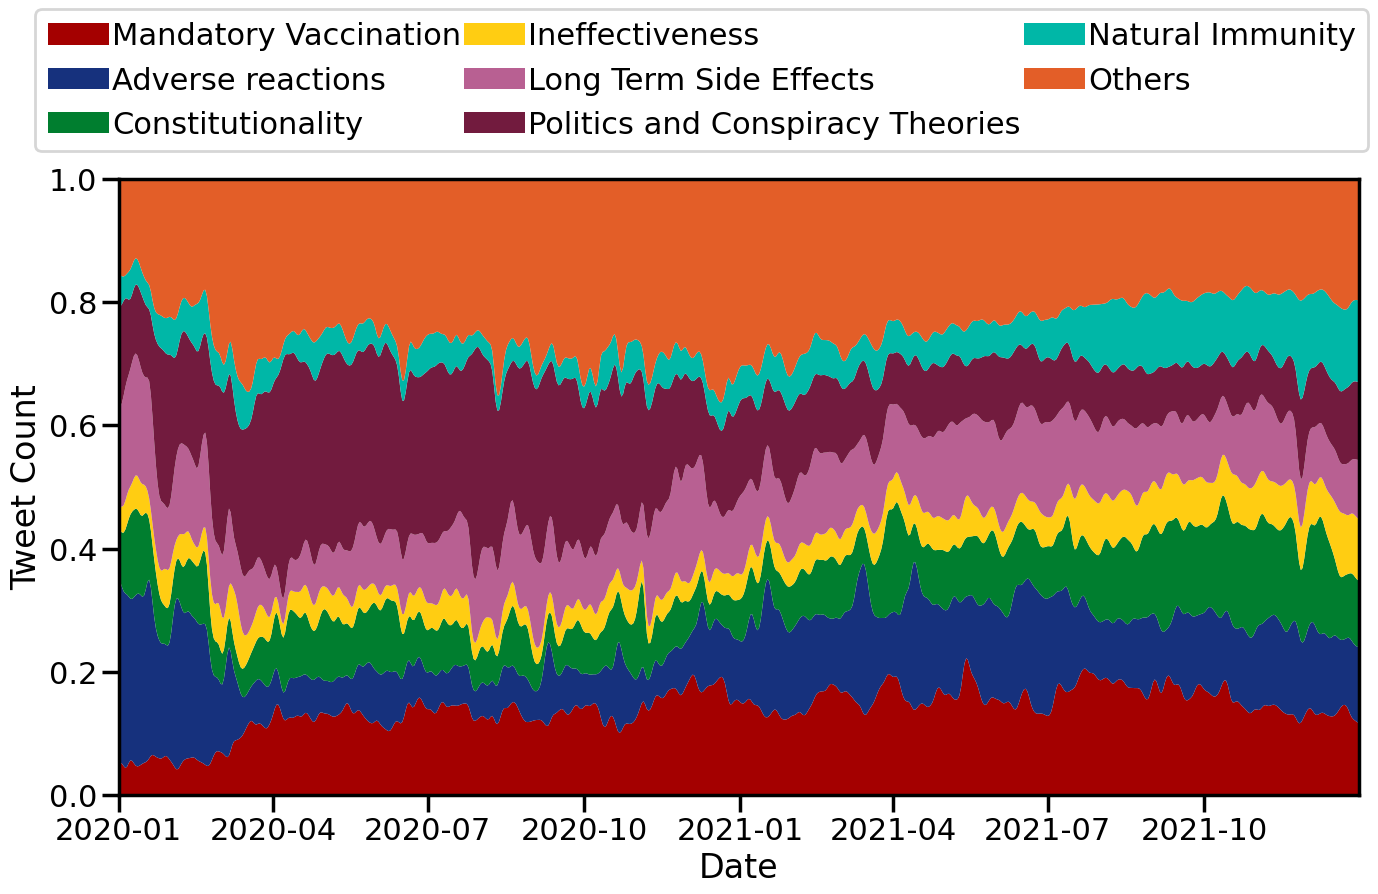

In [ ]:
sns.set_context("poster", font_scale=1)
fig, ax = plt.subplots(figsize=(16, 8))
plt.stackplot(pd.to_datetime(date_topic_count.sort_values('date')['date'].unique()),
              y_smthd / np.sum(y_smthd, axis=0),
              labels=topic_names, #baseline='sym',
              alpha=1, colors=colors)
ax.set_xlabel('Date')
ax.set_ylabel('Tweet Count')
ax.margins(x=0, y=0)
ax.legend(bbox_to_anchor =(1.020, 1.3), ncol=3, columnspacing=0.1, handletextpad=0.1)
plt.savefig(f'{supp_figures_path}/stachgraph_topic_modeling_smthd_percentage.pdf', bbox_inches='tight')

# Scatter PCA

In [12]:
fisher_exact = pd.read_csv(f"{dataframes_path}/fisher_exact_test_results_ctm.parquet")
fisher_exact = fisher_exact[fisher_exact['state'].isin(main_configs['us_51_state'])]

In [13]:
def y_axis_format(x, pos):
    """The two args are the value and tick position"""
    if x == 10.0:
        return "10.0+"
    else:
        return x
        
y_axis_format = FuncFormatter(y_axis_format)

def limit_values(x):
    if x < 10.0:
        return x
    else:
        return 10.0

limit_values = np.vectorize(limit_values)

fisher_exact['padj'] = limit_values(fisher_exact['padj'].values)

In [25]:
uppercase_letters = string.ascii_uppercase
plot_letters = [uppercase_letters[i] for i in range(len(uppercase_letters)) if i % 2 != 0]

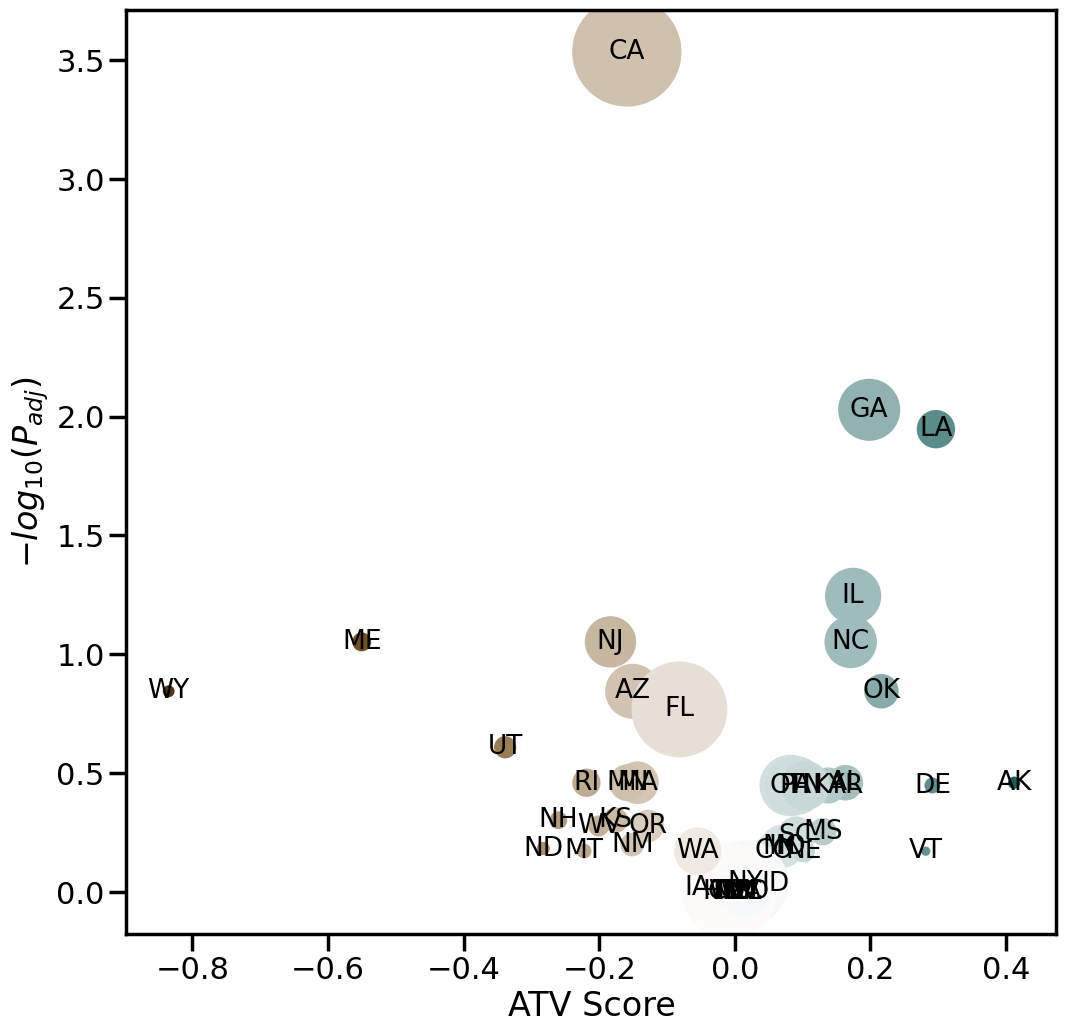

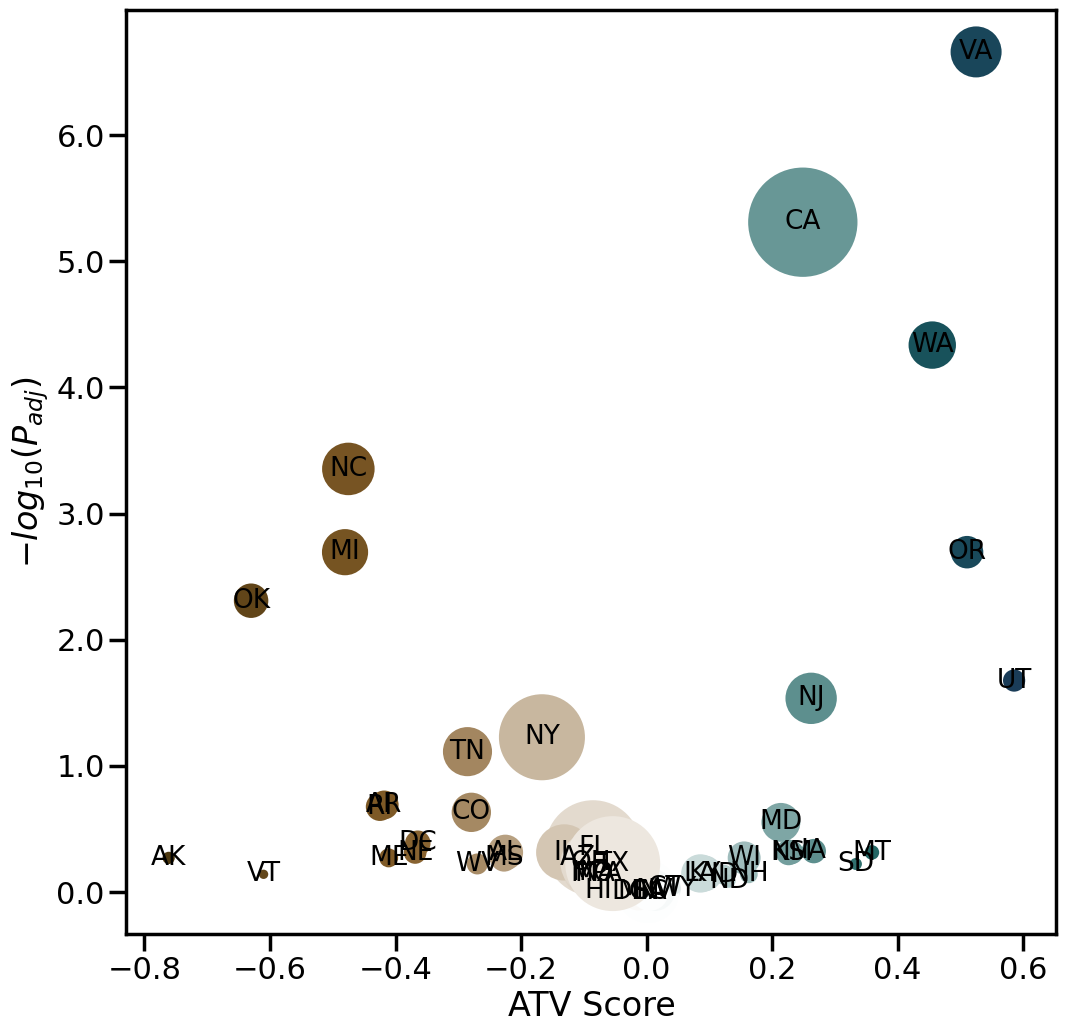

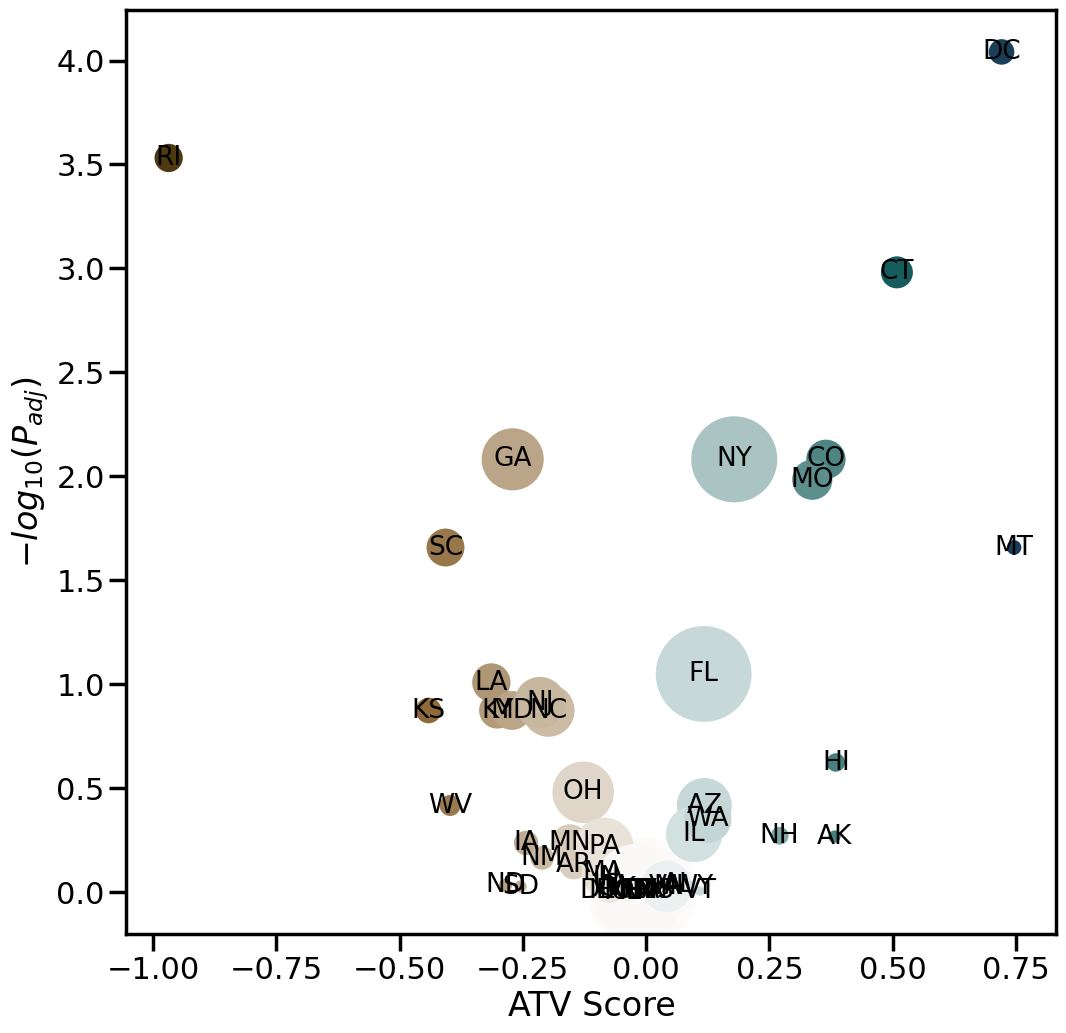

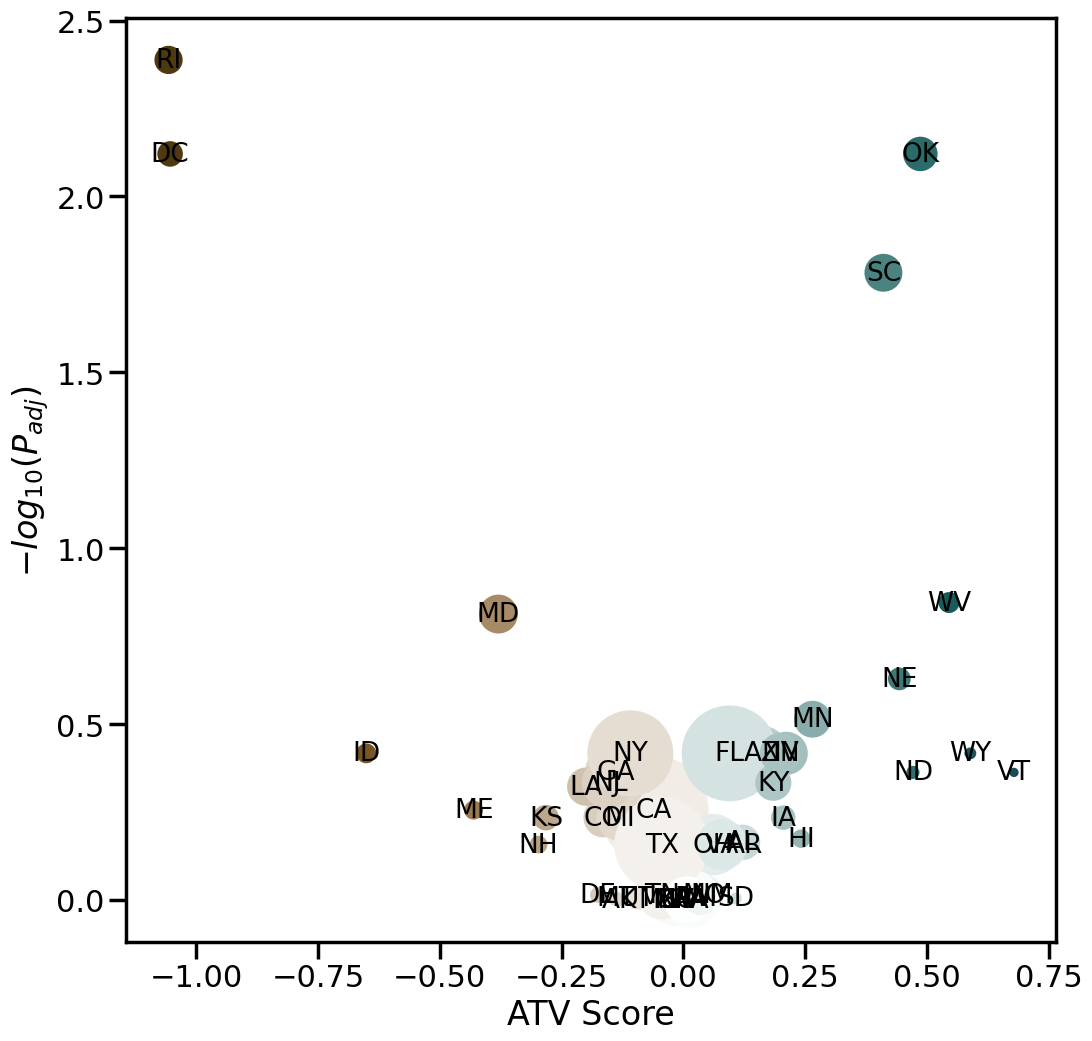

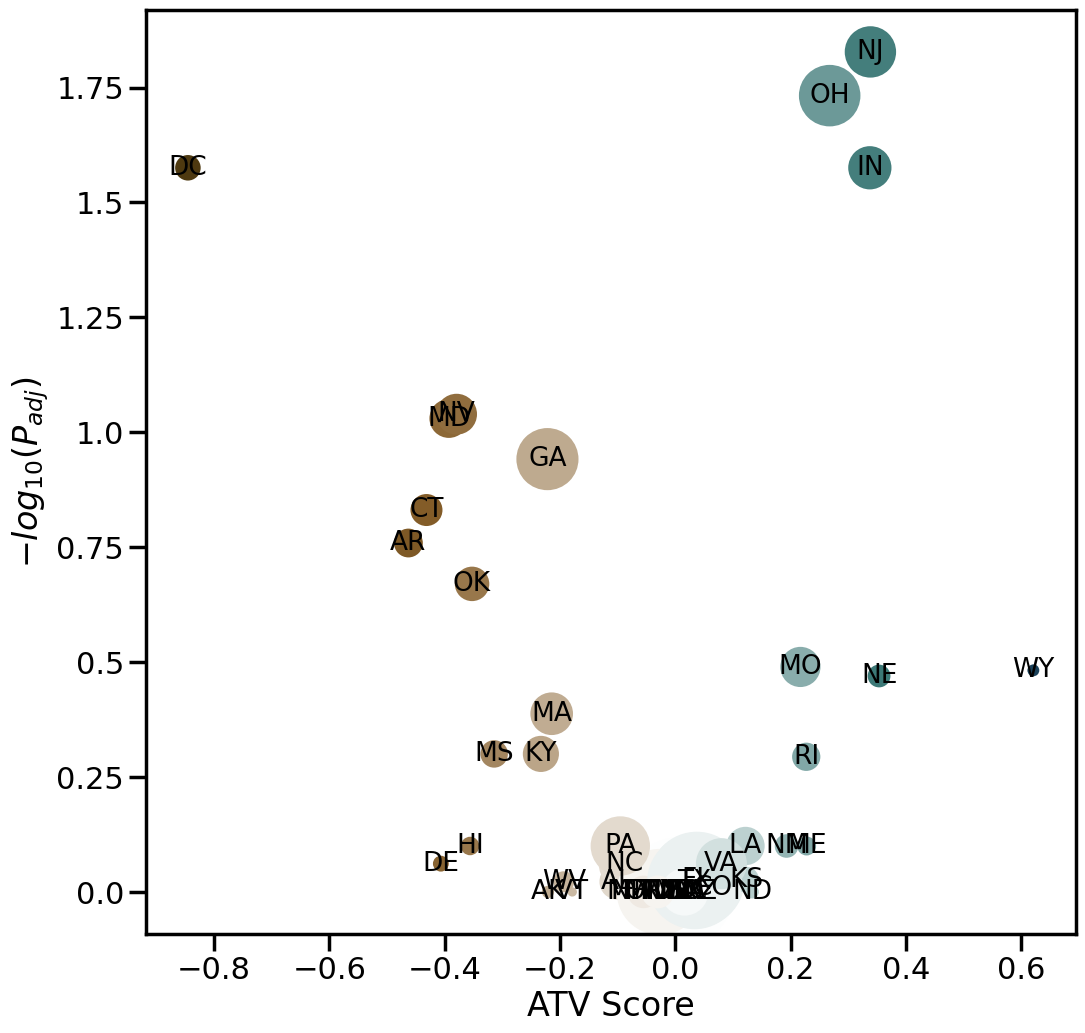

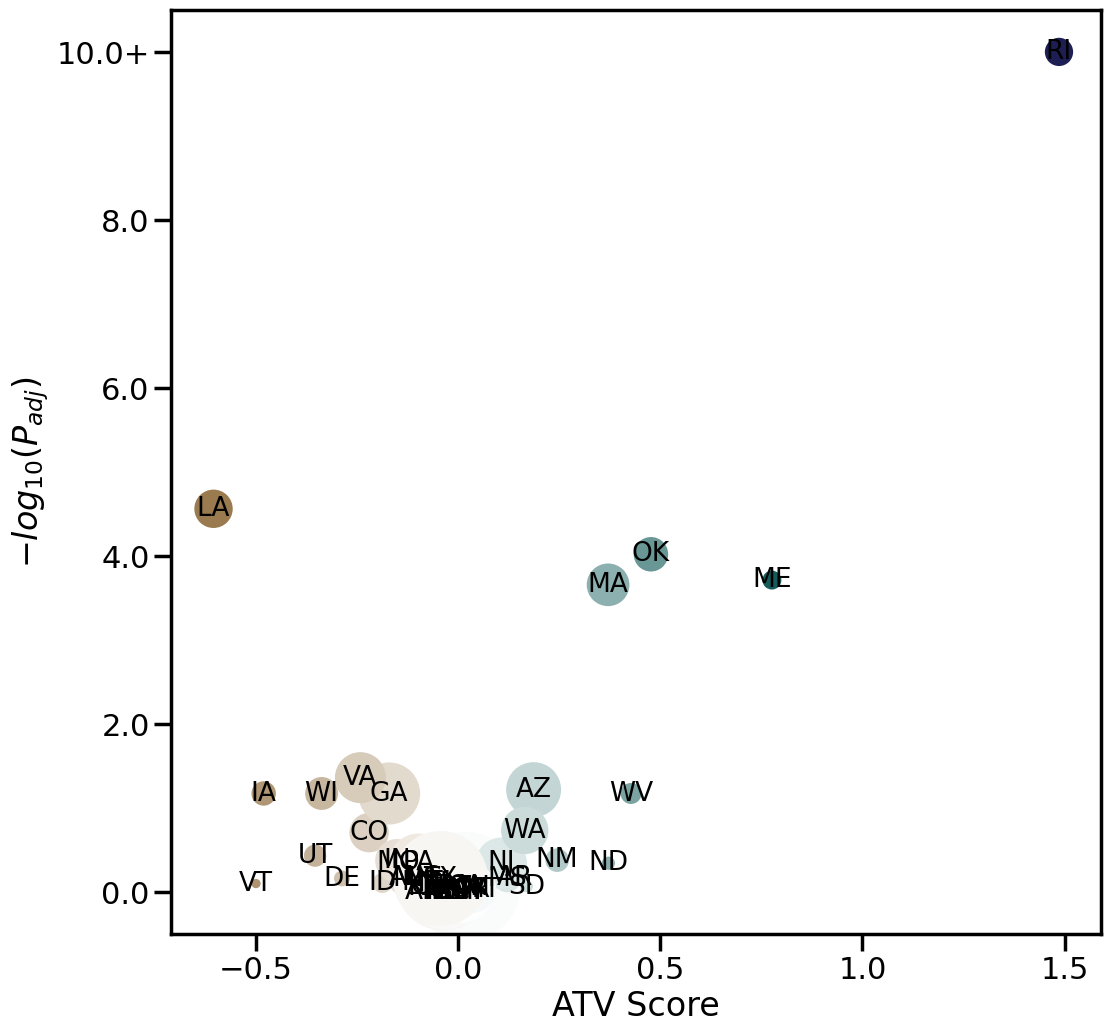

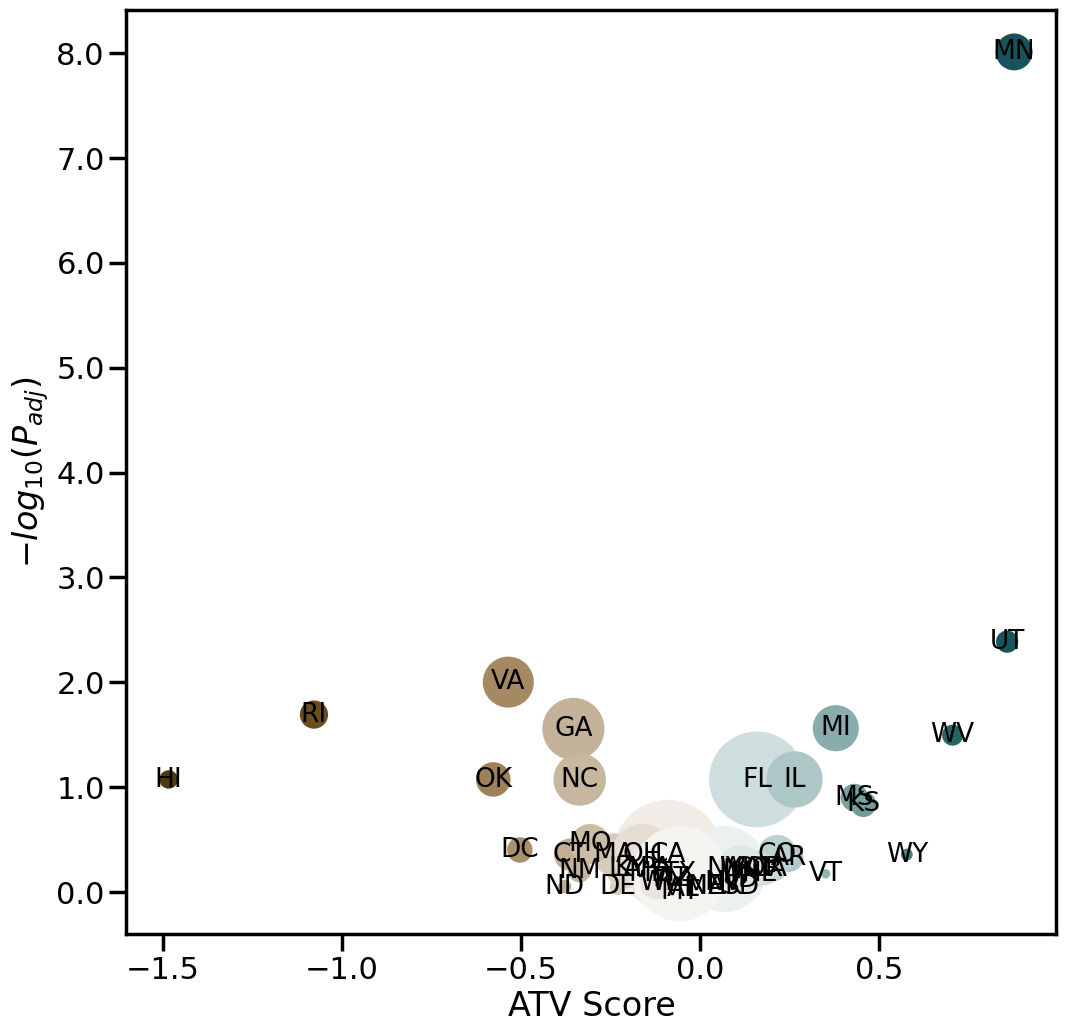

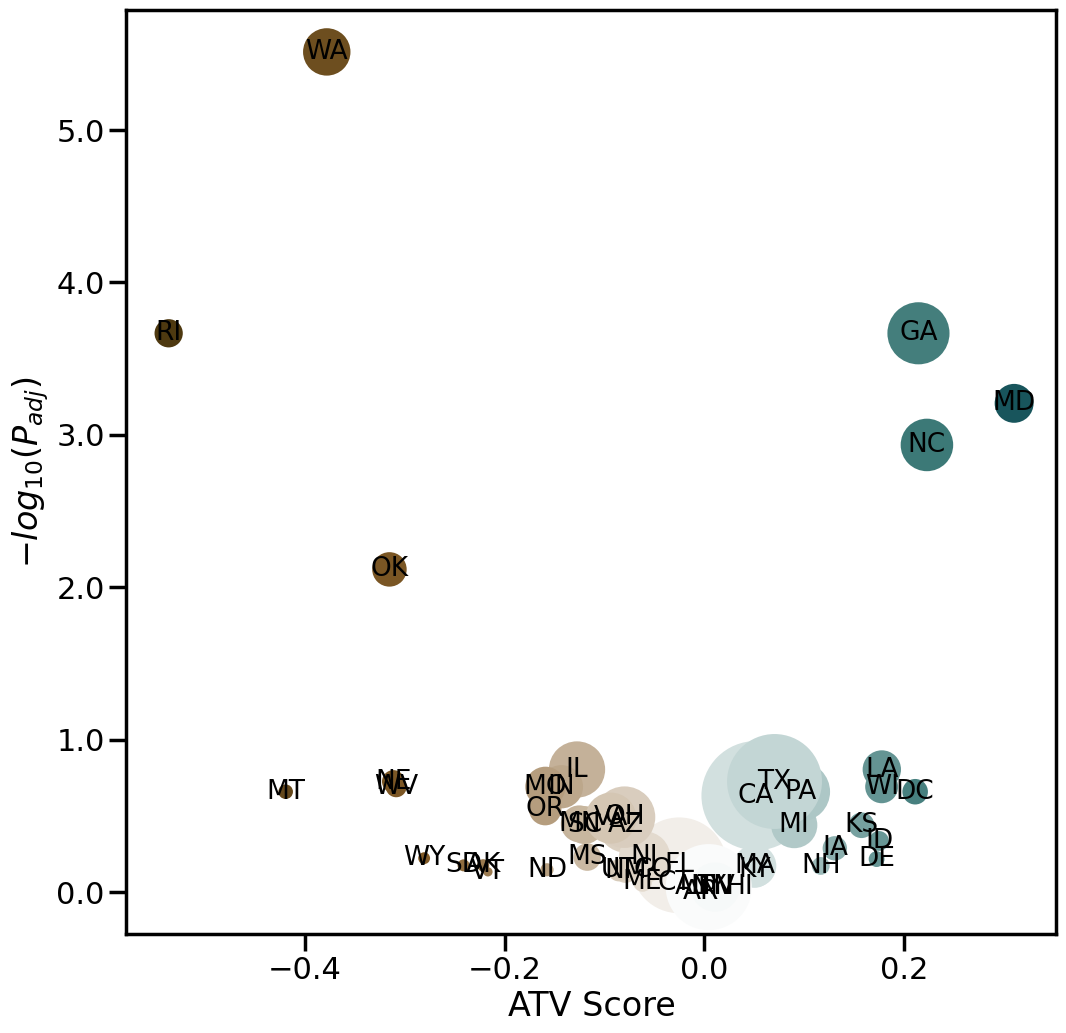

In [27]:
os.makedirs(f"{supp_figures_path}/ctm_volcano_plots", exist_ok=True)
colors=["#4e3910", "#845d29", 'white', "#175f5d", "#1d1f54"]

sns.reset_orig()
sns.set_context("poster", font_scale=1)

for topic in range(1, 9):
    save = f"{supp_figures_path}/ctm_volcano_plots/figure16{plot_letters[topic-1]}.svg"
    figures.volcano_plot(fisher_exact[fisher_exact['topic'] == topic], 'odd_ratios', 'padj',
                        colors, y_axis_formatter=y_axis_format,
                        point_size_multiplexer=1, figsize=(12, 12), save=None, paper_figure=save)